![Astrofisica Computacional](../logo.PNG)

---
## 24. Árboles de Decisión


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Resumen

En este cuaderno se presentarán los árboles de decisión como una herramienta para determinar el corrimiento al rojo de un conjunto de galaxias.

---

## Los Árboles de Decisión

A continuación utilizaremos los **árboles de decisión** desde la visión del machine learning, para determinar el redshift de una galaxia a partir de sus índices de color fotométricos. Para comenzar, describiremos como se reailzaría esta tarea clásicamente, para comprender las limitaciones de estos métodos y el por qué las herramientas de machine learning son ideales para este tipo de problemas.



### El conjunto de datos

El método usual para determinar el corrimiento al rojo de una galaxia distante implica la obtención de datos de las lineas de emisión (en visible) y la medición del desplazamiento en la longitud de onda de estas líneas. Sin embargo, este proceso suele implicar una graninversión de tiempo y no es eficiente para muestras grandes. Adicionalmente, para muchas de las galaxias conocidas no se han realizado observaciones espectroscópicas, por lo que este método no puede aplicarse.

Por esta razón, se intentará un método alternativo para calcular el corrimiento al rojo en el cual utilizaremos las **magnitudes de flujo** en las 5 bandas (u, g, r, i and z) reportadas en el catalogo Sloan Digital Sky Survey (SDSS). En el siguiente diagrama pueden identificarse estas 5 bandas en términos de las longitudes de onda.

<center>
<img
src="https://groklearning-cdn.com/modules/TYPnbyWbJVHGcaNudF4Nak/plot_sdss_filters_11.png"
>
</center>



En este repositorio se proporciona una base de datos denominada 'sdss_galaxy_colors.npy', en el formato de arreglo estructurado de `NumPy`, como un archivo binario con extensión `'.npy'`. 

La información de este tipo de arreglos estructurados puede encontrarse en

https://numpy.org/doc/stable/user/basics.rec.html

El primer paso es leer el archivo, lo cual puede realizarse con la función [np.load()](https://numpy.org/doc/stable/reference/generated/numpy.load.html)

In [1]:
import numpy as np

data = np.load('sdss_galaxy_colors.npy')
data

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       ...,
       (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05),
       (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295  , 4.505933e-04),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449 , 6.203324e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

En esta clase de estrucutra de datos, el atributo `.dtype` corresponde al nombre de las características. En este caso, se identifican las siguientes características:

| dtype | Feature|
|:-:|:-:|
|`u` |u band filter|
|`g` |g band filter|
|`r` |r band filter|
|`i` |i band filter|
|`z` |z band filter|
|`spec_class` |spectral class|
|`redshift` |redshift|
|`redshift_err` |redshift error|


In [2]:
data.dtype

dtype([('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

Paa visualizar una muestra particular se procede como cualquier arreglo,



In [3]:
data[1]

(19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703, 1.186625e-05)

In [4]:
data[0:4]

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       (19.05989, 17.49459, 16.59285, 16.09412, 15.70741, b'GALAXY', 0.04427702, 1.062687e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

Para visualizar una característica particular se utiliza,

In [5]:
data['u'] # data for the u filter

array([19.84132, 19.86318, 19.97362, ..., 19.82667, 19.98672, 18.00024])

In [6]:
data['redshift'] # Redshift data

array([0.539301  , 0.1645703 , 0.04190006, ..., 0.0784592 , 1.567295  ,
       0.4749449 ])

El número de muestras (i.e. galaxias) en la base de datos es

In [7]:
n = data.size
n

50000

---
### Correlación entre Corrimiento al Rojo y los Índices de Color 

El índice de color (o color astronómico) es la diferencia entre las magnitudes en dos filtros y son una aproximación del espectro del objeto observado. Los índices de color son útiles para la clasificación de estrellas y/o galaxias. Por ejemplo, un índice de color `'u - g'` negativo indica que el objeto es más brillante en las frecuencias del ultravioleta que en las frecuencias del verde.

El objetivo final de esta práctica es encontrar un modelo que permita predecir cómo cambia la variable independiente (corrimiento al rojo) con una o más de las variables dependientes (índices de color). Una posibilidad para encontrar esta relación es utilizar una regresión (lineal o de otro tipo). Por ello, graficaremos estas cantidades para observar como se relacionan. 

**1. Gráfico del comportamiento del corrimiento al rojo contra cada uno de los índices de color (u-g, g-i, r-i and i-z).**

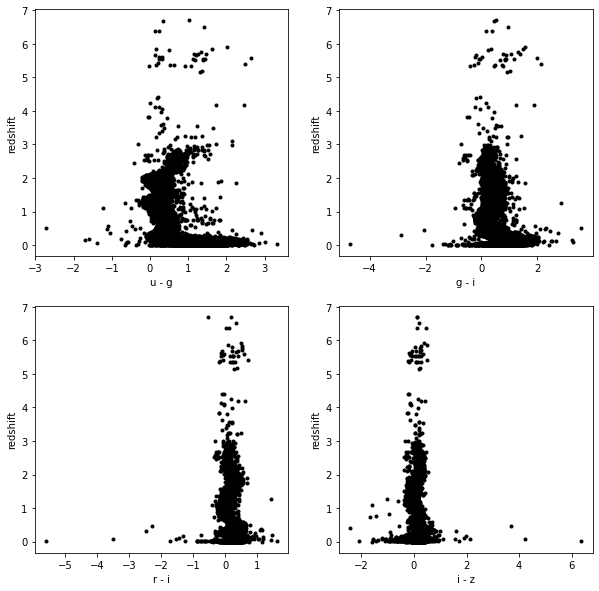

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot of the color indices u-g, g-i, r-i and i-z vs redshift
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].scatter(data['u']-data['g'], data['redshift'], color='black', marker='.')
ax[0,1].scatter(data['g']-data['i'], data['redshift'], color='black', marker='.')
ax[1,0].scatter(data['r']-data['i'], data['redshift'], color='black', marker='.')
ax[1,1].scatter(data['i']-data['z'], data['redshift'], color='black', marker='.')
ax[0,0].set_ylabel(r'redshift')
ax[0,0].set_xlabel(r'u - g')
ax[0,1].set_ylabel(r'redshift')
ax[0,1].set_xlabel(r'g - i')
ax[1,0].set_ylabel(r'redshift')
ax[1,0].set_xlabel(r'r - i')
ax[1,1].set_ylabel(r'redshift')
ax[1,1].set_xlabel(r'i - z')
plt.show()

De estos gráficos, es claro que no existe una relación linear simple entre el corrimiento al rojo y los índices de color.

De esta forma, debemos explorar otro método como, por ejemplo, un modelo de regresión multivariado no-lineal. Sin emabrgo, utilizar un ajuste de mínimos cuadrados para determinar los mejors parámetros puede dar un resultado bastante complejo y no hay garantía de buenos resultados. Con el fin de visualizar esta posibilidad, graficaremos la información de dos índices de color junto con el corrimiento al rojo representado con un mapa de color. Esto se puede realizar utilizando la función  [matplotlib.pyplot.scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) con los argumentos`s`, `c` y `cmap`. 

**2. Gráfico de los índices de color `'u-g'` (en el eje-x) y `'r-i'` (en el eje-y) contra el corrimiento al rojo (representado por un gradiente de color)**

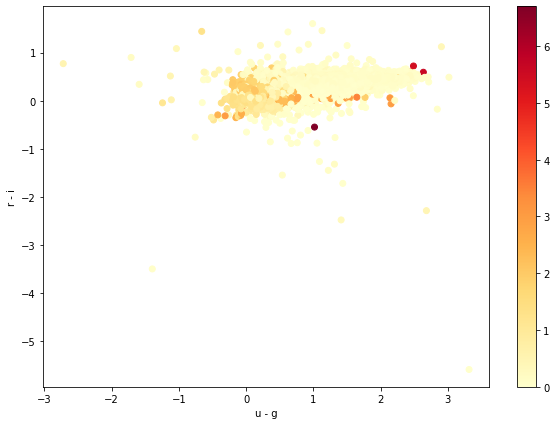

In [9]:
# Color gradient plot representign redshift
# vs. the color indices u-g and r-i

# Recommended colour map
cmap1 = plt.get_cmap('YlOrRd')
plt.figure(figsize=(10,7))
plt.scatter(data['u']-data['g'],data['r']-data['i'], c=data['redshift'], cmap=cmap1)
plt.ylabel(r'r - i')
plt.xlabel(r'u - g')
plt.colorbar()
plt.show()

Esta figura muestra que existen algunas regiones, razonablemente bien definidas, donde el corrimiento al rojo tiene valores similares. De esta forma, si se realiza un mapa de contornos de los corrimientos al rojo en este diagrama de índices de color, sería posible estimar el corrimiento al rojo para nuevos puntos basandose en la combinación de sus índices de color. Sin embargo, debido a la dispersión de los puntos en el diagrama, se tendrían incertidumbres significativas para los estimados del corrimiento al rojo.


---
### Árboles de Decisión 

Los **Árboles de Decisión** son una herramienta del machine learning que puede utilizarse tanto para tareas de **clasificación** como para tareas de **regresión**. Para este algoritmo se utiliza un conjunto de características de entrada que son mapeadas al correspondientes conjunto de datos objetivo. El entrenamiento del algoritmo se realiza a trvés de una serie de decisiones individuales en donde cda una de las dicisiones representa un nodo (o bifurcación/ramificación) del árbol. Cada decisión se realiza utilizando una sola de las características de los datos y el punto final de todas las ramas es un conjunto de los valores objetivo.

Un ejmplo de este tipo de herramientas puede observarse en la siguiente figura, tomada del artículo

E. C. Vasconcellos et al. *Decision Tree Clasifiers for Star/Galaxy separation*. AJ 141, 189 (2011).

En esta figura se muestra un árbol de decisión en el cual los valores de algunas propiedades físicas son usadas para crear los nodos.


<center>
<img src="https://cdn.iopscience.com/images/1538-3881/141/6/189/Full/aj385906f1_lr.jpg">
</center>

Las decisiones en cada rama se determinan a partir de los datos de entrenamiento y por el algoritmo de los árboles de decisión. En la práctica, cada algoritmo particular emplea una **métrica** para encontrar la decisión que dividirá los datos de forma más efectiva.


---

Ahora utilizaremos los índices de color fotométricos como los datos de entrada y los objetivos (datos de salida) serán los corrimientos al rojo. El entrenamiento del algoritmo deberá dar como resultado un árbol similar al que se muestra en la siguiente figura:

<center>
<img src="https://groklearning-cdn.com/modules/5PUcnT5fqRn5wTUXw7kg2B/decisiontree_1.png" width=450>
</center>

Nótese que cada nodo involucra sólamente uno de los índices de color. Al seguir los posibles caminos a lo largo del árbol, se llega a un valor objetivo, correspondiente al corrimiento al rojo particular del objeto.



### Preparación de los Conjuntos de Características y de Objetivo

Para entrenar el algoritmo de machine learning debemos escribir la información de entrada adecuadamente. Primero, los indices de color 'u-g', 'g-i', 'r-i' e 'i-z' se reunirán enn un arreglo llamada `'features'`. Luego, los corrimientos al rojo se localizarán en el arreglo llamado `'targets'`.

**1. Definición de las variables 'features' (indices de color) y 'targets' (corrimientos al rojo)**

In [10]:
# Function returning the 4 color indices and the redshifts

features = np.asarray([data['u']-data['g'],\
                       data['g']-data['i'],\
                       data['r']-data['i'],\
                       data['i']-data['z'] ])

targets = np.asarray(data['redshift'])
features.shape

(4, 50000)

La forma del conjunto de características debe cambiarse para que los indices de color queden ubicados en las columnas.

In [11]:
# Change the shape of the array. Features in the columns, samples in the rows.
features = features.T
features.shape

(50000, 4)

In [12]:
targets.shape

(50000,)

### Árboles de Decisión en `SciKit Learn`

Dentro del paquete `SciKit Learn` encontraremos la función [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html).

De forma similar al modelo lineal que se implementó en la clase anterior, el árbol de decisión tomará los datos de entrenamiento ('features' y 'targets') para entrenar o construir el modelo que luego podrá ser aplicado a otros datos para predecir el resultado. Para iniciar el árbol de decisión, creamos una variable que guardará el modelo,


In [14]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor()

In [15]:
dec_tree

DecisionTreeRegressor()

Luego entrenamos el algoritmo con el método `.fit()` y los arreglos 'features' y 'targets',

In [16]:
dec_tree.fit(features, targets)

DecisionTreeRegressor()

Una vez que el árbol de decisión ha sido creado, utilizaremos el método `.predict()` para predecir los valores de corrimiento al rojo de nuevos objetos. Por ejemplo, podemos utilizar el mismo conjunto de entrenamiento 'features' para predecir sus valores de corrimiento que pueden ser comparados con los datos del arreglo 'targets'.

In [17]:
predictions = dec_tree.predict(features)

In [18]:
predictions

array([0.539301  , 0.1645703 , 0.04190006, ..., 0.0784592 , 1.567295  ,
       0.4749449 ])

#### Evaluación de las predicciones

Para evaluar los resultados del árbol de decisión, calcularemos la diferencia entre los datos predichos y los datos del arreglo 'targets'. Estas diferencias comunmente se denominan **residuos** y para caracterizar el resultado utilizaremos la mediana de estos valores,

\begin{equation}
\text{eval_dec_tree} = \text{median}\left\lbrace \left| \text{predictions}_i - \text{targets}_i \right|\right\rbrace
\end{equation}

**2. Implementación de la función que calcula la mediana de las diferencias entre predicción y objetivos (residuos). Nótese que se utiliza el valor absoluto de estas diferencias.**

In [19]:
eval_dec_tree = np.median(np.abs(predictions - targets))
eval_dec_tree

0.0

Este resultado indica que el árbol de decisión funciona perfectamente con los datos de entrenamiento. Sin embargo, para poder medir adecuadamente un árbol de decisión es necesario aplicarlo a un conjunto de datos diferente al del entrenamiento.

### Implementando conjuntos de entrenamiento y prueba

Como se dijo antes, es necesario implementar conjuntos de entrenamineto y prueba diferentes entre si para lograr una medición adecuada de la precisión del árbol de decisión creado. 


**3. División de los arreglos 'features' y 'targets' en subconjuntos de entrenamiento y prueba (50:50)**

In [20]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_targets, test_targets = train_test_split(features, targets, random_state=60, test_size=0.5)

In [22]:
train_features.shape

(25000, 4)

In [23]:
test_features.shape

(25000, 4)

**4. Uso de los conjuntos de entrenamiento para crear el árbol de decisión.**

In [24]:
d_tree = DecisionTreeRegressor()
d_tree.fit(train_features, train_targets)

DecisionTreeRegressor()

**5. Uso de los subconjuntos de prueba para predecir el corrimiento al rojo y evaluar el modelo.**

In [25]:
predictions_d_tree = d_tree.predict(test_features)
eval_d_tree = np.median(np.abs(predictions_d_tree - test_targets))
eval_d_tree

0.021946535

---

#### Interpretación de la Evaluación del Modelo

El resultado obtenido de $\approx 0.02$ en la mediana de los residuos indica que la mitad de las muestras tendrán un error en la predicción $< 0.02$.

Al tomar como medida estadística de la precisión la mediana de los residuos  se obtiene una buena representación de los errores, especialmente cuando la distribución de estos esta sesgada. 

In [26]:
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

NameError: name 'X' is not defined

<Figure size 432x288 with 0 Axes>